In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import yaml
#from dotenv import load_dotenv
from langchain.agents import initialize_agent, Tool
from langchain.agents.agent_types import AgentType
from langchain.llms import OpenAI

import Mandelbrot #defined/customized functions from Mandelbrot.py

import scipy
from scipy.stats import norm, cauchy, lognorm, expon, kstest
#from langchain_openai import OpenAI

from langchain.tools import tool
import requests

#telegram bot
from telegram import Update
from telegram.ext import ApplicationBuilder, ContextTypes, MessageHandler, filters

In [3]:
#set fixed parameters 


### OPENAI API ###
with open('/home/christiane/git/stash/API/openai_api.yml', 'r') as file:
    OPENAI_API_KEY = yaml.safe_load(file)["api"]

### TELEGRAM API ###
with open('/home/christiane/git/stash/API/telegram_api.yml', 'r') as file:
    TELEGRAM_TOKEN = yaml.safe_load(file)["api"]
    
#check api key
#print(OPENAI_API_KEY)
#print(TELEGRAM_TOKEN)


### URL Coingecko ###
#url_coingecko = f"https://api.coingecko.com/api/v3/simple/price?ids={symbol.lower()}&vs_currencies=usd"
#print(url_coingecko)

In [4]:
# Initialize LLM

#OpenAI?

#temperature
# 0-0.3 -> focused/predictable
# 0.7-1.0-> creative mode

llm = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)


/tmp/ipykernel_159282/1532271086.py:9: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)


In [5]:
# Tool 1: Fetch current Crypto Price

@tool
def get_crypto_price_current(symbol: str) -> str:
    """Returns the current price of a given cryptocurrency symbol (e.g., BTC, ETH) using CoinGecko API"""
     #fix for user input BTC&bitcoin
    print(symbol)
    COIN_LOOKUP = {
        "btc": "bitcoin",
        "bitcoin": "bitcoin",
        "eth": "ethereum",
        "ethereum": "ethereum",
        "sol": "solana",
        "solana": "solana",
        "ada": "cardano",
        "cardano": "cardano",
        "doge": "dogecoin",
        "dogecoin": "dogecoin",
    }
    
    
    try:
        #for coingecko it has to be full name+lowercase
        coin_lowercase = symbol.strip().lower()   #symbol gets generated from package llm (extracted from input)
        coin_id = COIN_LOOKUP[coin_lowercase]     
        url = f"https://api.coingecko.com/api/v3/simple/price?ids={coin_id}&vs_currencies=eur"
        response = requests.get(url).json()
        price = response[coin_id]["eur"]
        return f"The current price of {coin_id} is {price}€"
    
    except Exception as e:
        return f"Error fetching price: {e}"

    


In [27]:
# Tool 2 Fetch history max of cryptocurrency

@tool
def get_crypto_price_history(symbol: str) -> str:
    url = f"https://api.coingecko.com/api/v3/coins/{symbol.lower()}/market_chart?vs_currency=eur&days=max"
    try:
        response = requests.get(url).json()
        price = response[symbol.lower()]["eur"]

SyntaxError: incomplete input (3127424064.py, line 8)

In [1]:
data= Mandelbrot.historical_data(crypto="BTC", curr="EUR", gran="m")
#data_minute = Mandelbrot.historical_data(crypto="BTC", curr="EUR", gran="minute")
print(data.head())

NameError: name 'Mandelbrot' is not defined

In [7]:
print(data.columns)
print(len(data))
data.head()

Index(['unix', 'date', 'high', 'low', 'delta_high', 'delta_low'], dtype='object')
824488


,unix,date,high,low,delta_high,delta_low
0,1609700280,2021-01-03 18:58:00,26014.45,25952.41,NaN,NaN
1,1609700340,2021-01-03 18:59:00,26087.32,25994.39,72.87,41.98
2,1609700400,2021-01-03 19:00:00,26028.02,25959.78,-59.30,-34.61
3,1609700460,2021-01-03 19:01:00,25981.86,25954.63,-46.16,-5.15
4,1609700520,2021-01-03 19:02:00,26066.23,25963.80,84.37,9.17


In [5]:
df = Mandelbrot.historical_data(crypto="BTC", curr="EUR", gran="m")

downloading the EUR price/m for BTC from https://www.cryptodatadownload.com/cdd/Binance_BTCEUR_minute.csv....
downloading the EUR price/m for BTC from yfinance....
merge dataframes


In [9]:
df.head()

,unix,date,high,low,delta_high,delta_low
0,1609700280,2021-01-03 18:58:00,26014.45,25952.41,NaN,NaN
1,1609700340,2021-01-03 18:59:00,26087.32,25994.39,72.87,41.98
2,1609700400,2021-01-03 19:00:00,26028.02,25959.78,-59.30,-34.61
3,1609700460,2021-01-03 19:01:00,25981.86,25954.63,-46.16,-5.15
4,1609700520,2021-01-03 19:02:00,26066.23,25963.80,84.37,9.17


In [16]:
H = df[df.date.dt.minute == 0 ]
H.head()

,unix,date,high,low,delta_high,delta_low
2,1609700400,2021-01-03 19:00:00,26028.02,25959.78,-59.30,-34.61
62,1609704000,2021-01-03 20:00:00,25924.91,25896.15,-2.16,2.74
122,1609707600,2021-01-03 21:00:00,26670.77,26621.29,6.80,4.23
182,1609711200,2021-01-03 22:00:00,26580.99,26478.00,-9.86,-100.40
242,1609714800,2021-01-03 23:00:00,26224.14,26143.79,5.41,-33.98


In [2]:
# get DF with different granularity

MIN, HOUR, DAY, WEEK, MONTH = Mandelbrot.historical_datasets(crypto="BTC", curr="EUR")


downloading the EUR price/m for BTC from https://www.cryptodatadownload.com/cdd/Binance_BTCEUR_minute.csv....
downloading the EUR price/m for BTC from yfinance....
merge dataframes
downloading the EUR price/d for BTC from https://www.cryptodatadownload.com/cdd/Binance_BTCEUR_d.csv....
downloading the EUR price/d for BTC from yfinance....
merge dataframes


/home/christiane/git/MOM_Crypto_Bot/agent/Mandelbrot.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOUR["delta_high"] = HOUR["high"].diff()
/home/christiane/git/MOM_Crypto_Bot/agent/Mandelbrot.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HOUR["delta_low"] = HOUR["low"].diff()
/home/christiane/git/MOM_Crypto_Bot/agent/Mandelbrot.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [3]:
df = DAY

[nan, -0.775472401825323, -1.3903820901528157, 0.018395825412386844, -0.9280712049099684, -0.7020340092541884, 1.4351315257544577, -0.6431386932936758, -0.8955818974327147, -0.7856994752680366, -0.6729722796761102, -0.6454625680667018, -1.1119886393849179, 0.7989377052056565, -0.1790302300970597, -0.7428640204084518, -0.7274168438497168, -0.9092324682842888, -1.2583270051560773, 0.16332330105826953, -0.7598683313756112, 0.9680203933935947, 1.372628417807508, -0.8068458715856465, -0.6493845420710055, 0.964759727306535, 1.0746280377912483, 1.0754709970521277, -0.7576208186627478, -0.8648047340287508, -0.9343461620762555, 0.8801263021690886, 0.019739126645791978, -0.4626894796086034, 0.4008776549969668, -0.4673096047509613, 0.07906462988696183, -1.2400582824062563, -0.5111241831906165, 0.29662569628231555, -0.15971409628106262, 0.07812408903784292, -0.35976185776213193, -0.44225789375939917, -0.3219490893823046, -0.6248475090486121, -0.962161795457887, 0.6877815501057606, -0.4038164852680

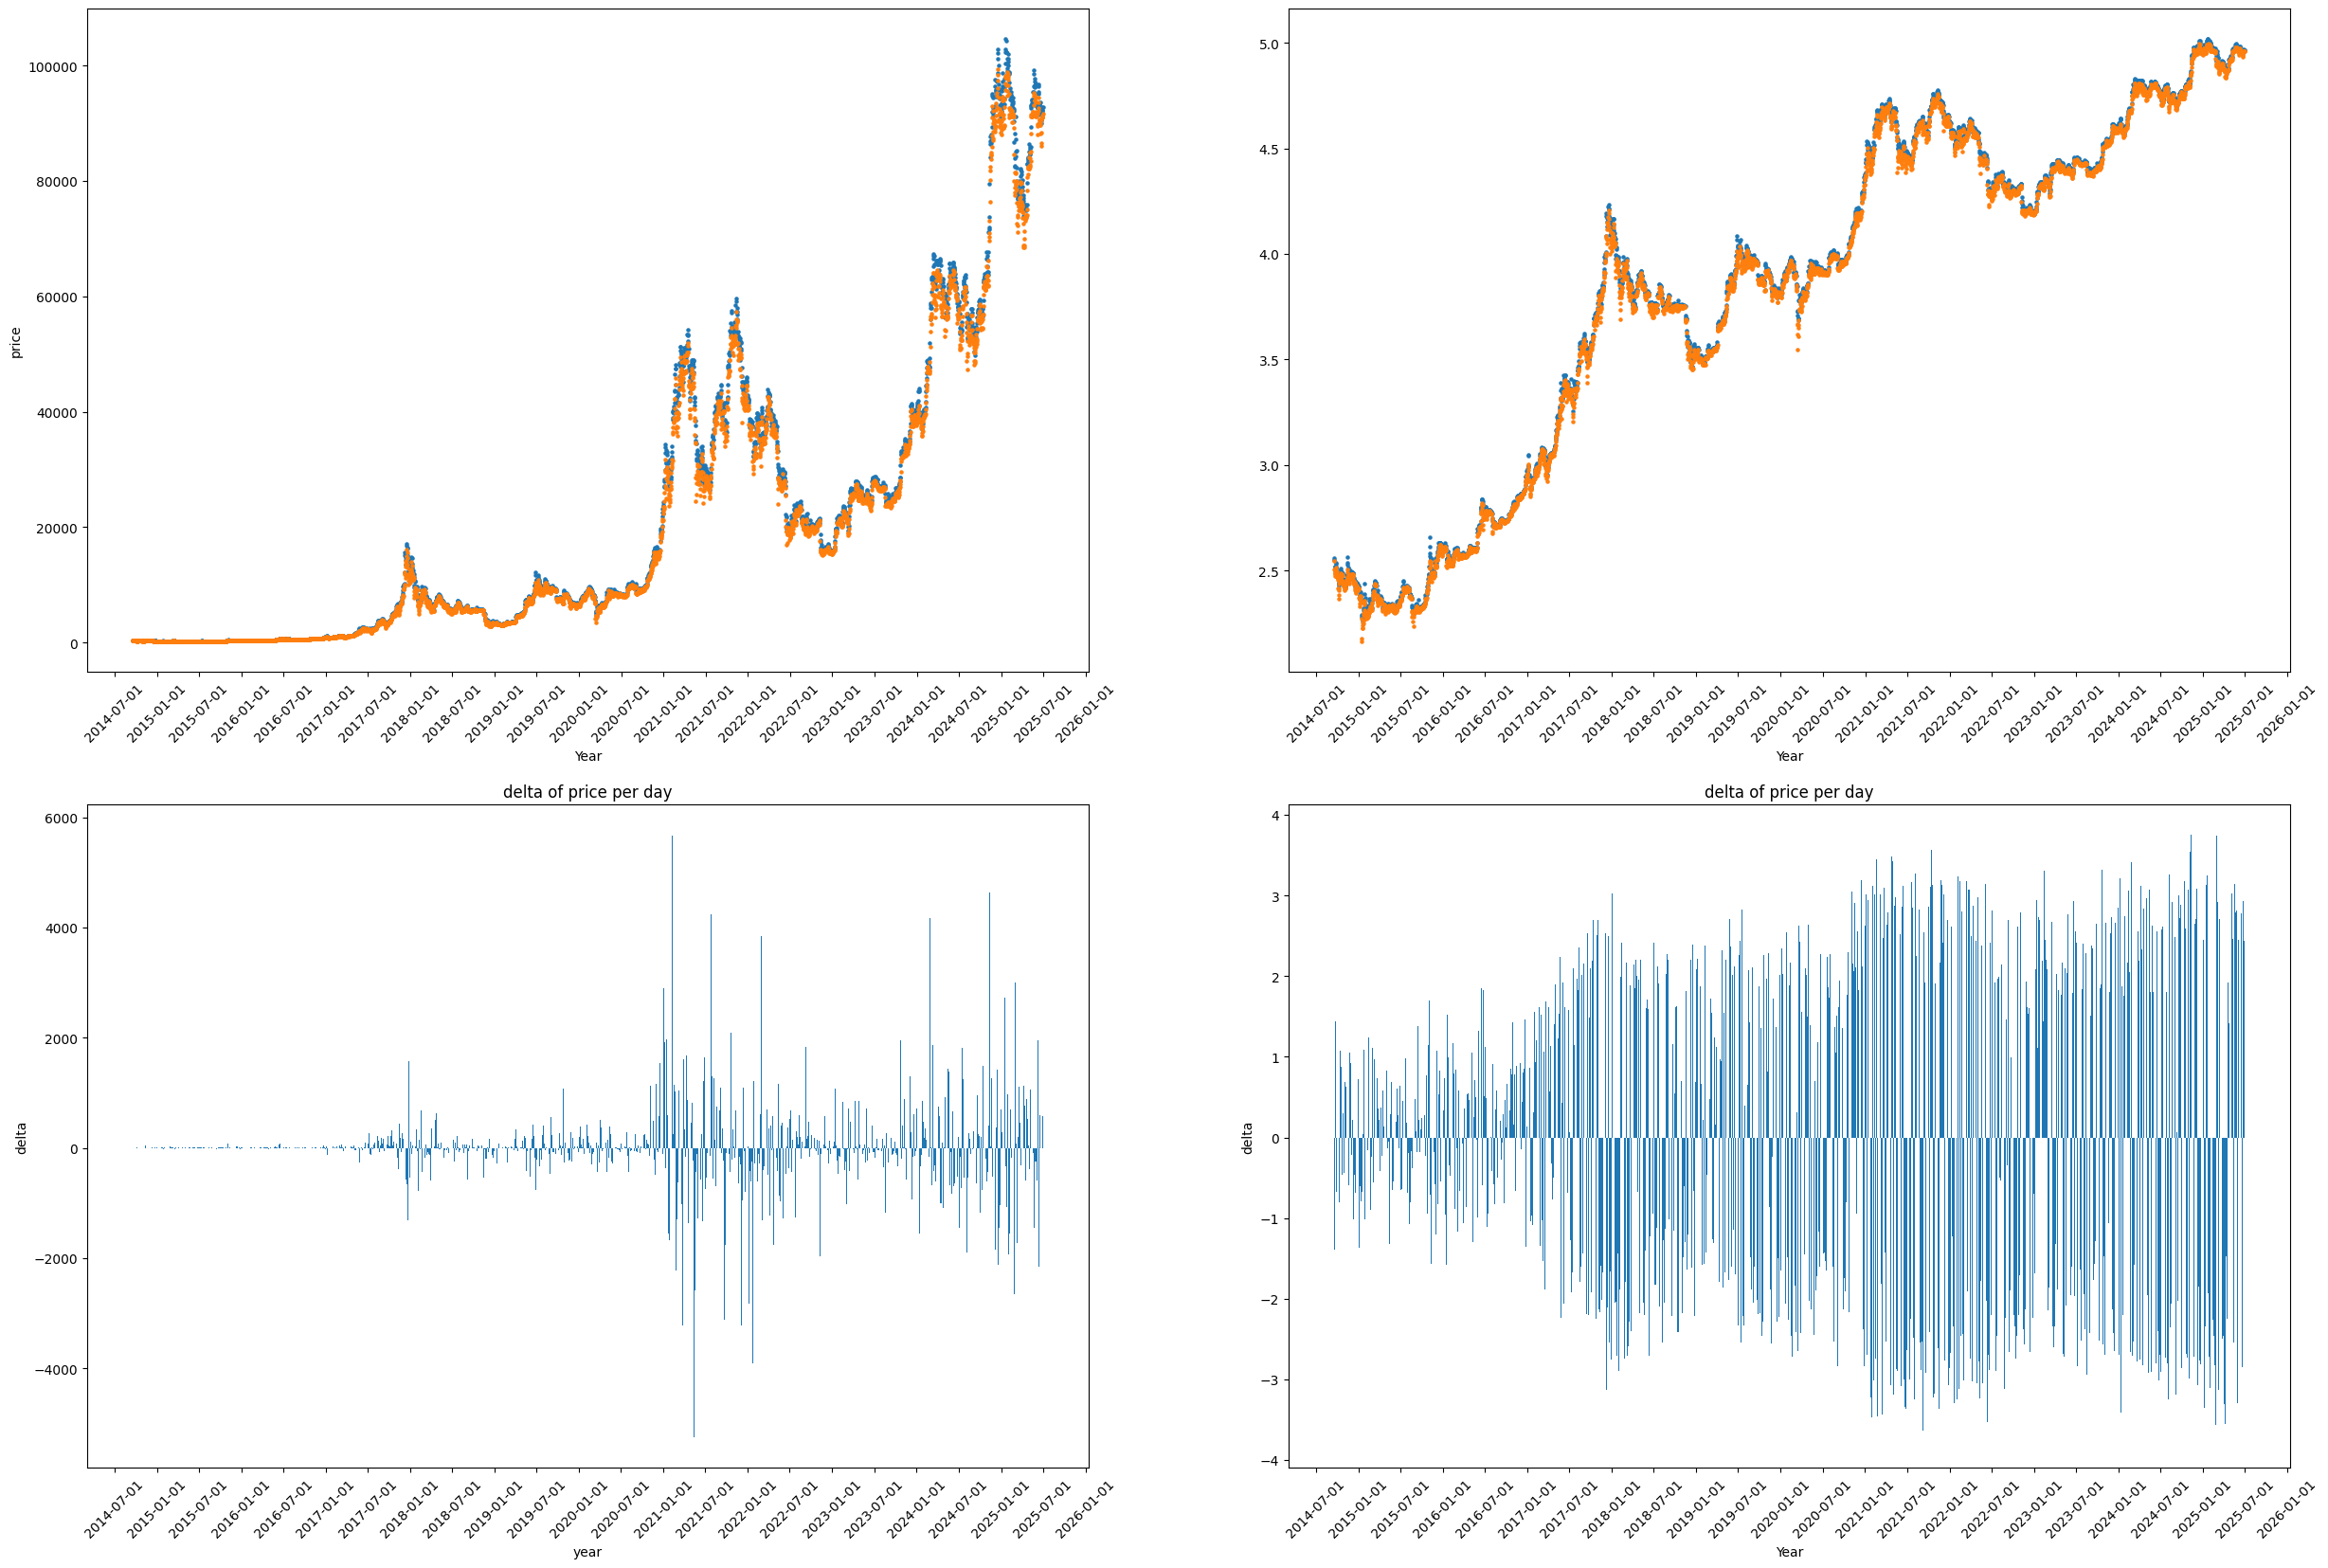

In [8]:
fig = plt.figure(figsize=(30,20))


plt.subplot(2, 2, 1)

plt.scatter(df["date"], df["high"], s=5, label="high")
plt.scatter(df["date"], df["low"], s=5, label="low")
#x-axis format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonth=(1,7)))

#rotate x axis
plt.xticks(rotation=45)
plt.xlabel("Year")

plt.ylabel("price")




plt.subplot(2, 2, 2)
plt.scatter(df["date"], Mandelbrot.log10(df["high"]), s=5, label="high")
plt.scatter(df["date"], Mandelbrot.log10(df["low"]), s=5, label="low")

#x-axis format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonth=(1,7)))

#rotate x axis
plt.xticks(rotation=45)
plt.xlabel("Year")





plt.subplot(2, 2, 3)
plt.bar(df["date"], df["delta_high"])
 
plt.xlabel("year")
plt.ylabel("delta")
#x-axis format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonth=(1,7)))

#rotate x axis
plt.xticks(rotation=45)
plt.title("delta of price per day")



print(Mandelbrot.log10(df["delta_high"])[0:50])

plt.subplot(2, 2, 4)
plt.bar(df["date"], Mandelbrot.log10(df["delta_high"]))

 
plt.xlabel("Year")
plt.ylabel("delta")
#x-axis format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonth=(1,7)))

#rotate x axis
plt.xticks(rotation=45)
plt.title("delta of price per day")

plt.show()

In [11]:
kstest?

In [12]:
scipy.stats.anderson

Object `anderson` not found.


In [4]:
import seaborn as sb
from pathlib import Path

distdict = yaml.safe_load(Path('static/dist_color.yml').read_text())

print(distdict)

{'cauchy': 'pink', 'expon': 'r', 'lognorm': 'g', 'norm': 'k'}


/home/christiane/naconda3/envs/MOM/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6918: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


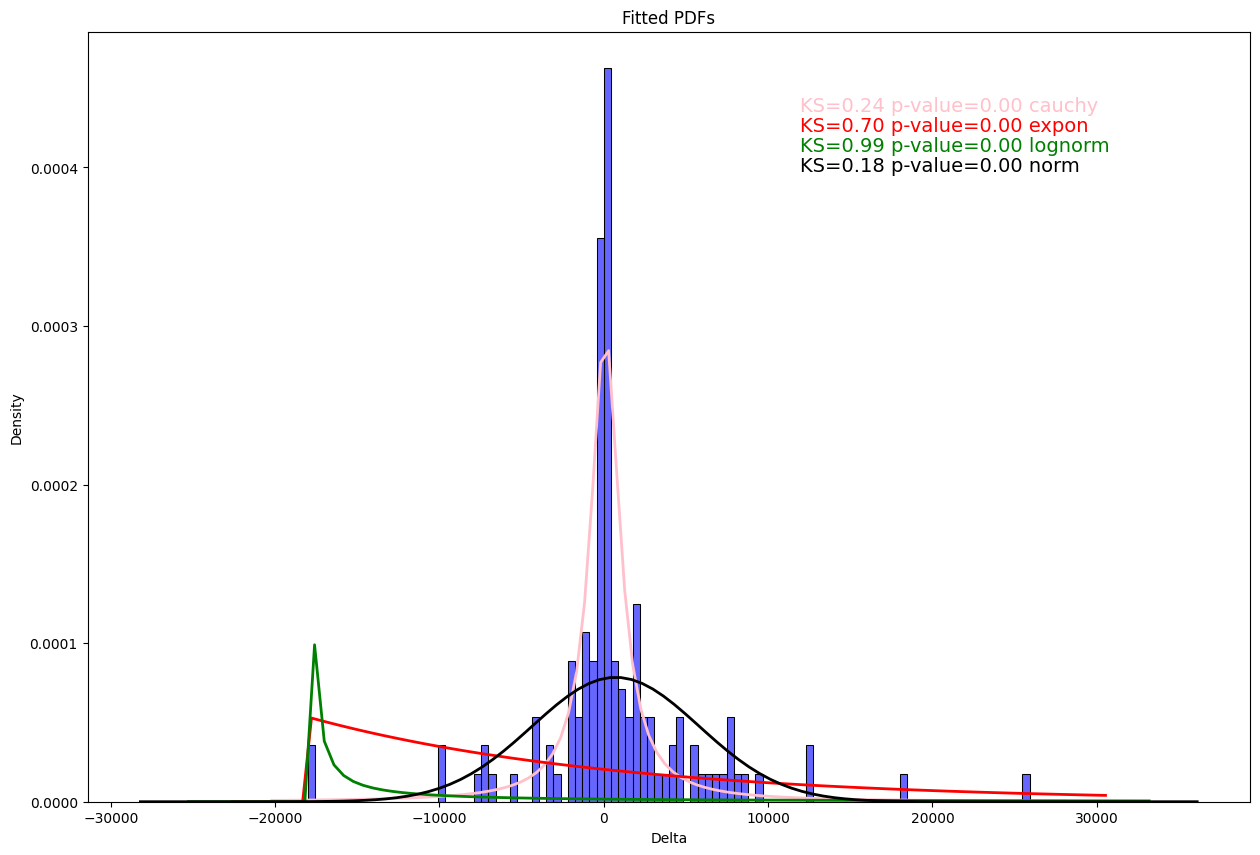

In [7]:
from scipy.stats import norm, cauchy, lognorm, expon, kstest
data = MONTH["delta_high"].dropna()

#plt.hist(data, bins=100, density=True)

plt.figure(figsize=(15,10))

sb.histplot(data, bins=100, kde=False, stat = "density", color = 'blue', alpha=0.6)

i=0.8
for pdf in distdict:
    
    params, pdf_fitted, x = Mandelbrot.calculate_pdf(data, pdf)
    pdf_fits = Mandelbrot.calculate_pdf_fit(data, params)
    
    plt.plot(x,pdf_fitted, 
         distdict[pdf], 
         linewidth=2, 
         label=pdf)
    plt.figtext(0.6, i,  
                'KS=%.2f p-value=%.2f %s'%(pdf_fits[0][0],
                                           pdf_fits[0][1], 
                                           pdf), 
                size=14, 
                c=distdict[pdf])
    i=i-0.02



#plt.legend(loc="upper right")
plt.xlabel('Delta')
plt.ylabel('Density')
plt.title('Fitted PDFs')
#plt.savefig("PDF.png")
plt.show()



In [8]:
print(pdf_fits)

[KstestResult(statistic=0.17594124883572348, pvalue=0.0006166689887034374, statistic_location=-1158.8046875, statistic_sign=-1), AndersonResult(statistic=7.572427083922776, critical_values=array([0.559, 0.637, 0.764, 0.892, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=723.4072576332092, scale=5104.73333461744)
 success: True
 message: '`anderson` successfully fit the distribution to the data.'), CramerVonMisesResult(statistic=11.274833623396487, pvalue=3.494083911093071e-10)]


In [8]:
combined_df = pd.concat([data_cdd, data_yf])
print(len(combined_df))

#combined_df = combined_df.drop_duplicates(subset='unix').sort_values('unix').reset_index(drop=True)
print(len(combined_df))

5933
5933


In [10]:
combined_df.tail()

,unix,date,high,low
3929,1750377600,2025-06-20 00:00:00+00:00,91791.828125,90706.203125
3930,1750464000,2025-06-21 00:00:00+00:00,92499.625000,88729.882812
3931,1750550400,2025-06-22 00:00:00+00:00,90256.257812,87603.406250
3932,1750636800,2025-06-23 00:00:00+00:00,89671.054688,85715.796875
3933,1750723200,2025-06-24 00:00:00+00:00,91234.585938,90363.492188


In [11]:
combined_df.head()

,unix,date,high,low
0,1750636800,2025-06-23,91507.13,86510.76
1,1750550400,2025-06-22,89829.03,85411.45
2,1750464000,2025-06-21,90361.30,87663.31
3,1750377600,2025-06-20,92480.78,88784.80
4,1750291200,2025-06-19,91750.00,90560.17


In [41]:
import yfinance as yf

def reset_index(df):
    df = df.reset_index()
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends','stock splits']
    df['unix'] = df["date"].astype('int64') // 10**9

    return df

btc = yf.Ticker("BTC-EUR")
history_day = reset_index(btc.history(period="max", interval="1d"))
history_hour = reset_index(btc.history(period="max", interval="60m"))
history_minute = reset_index(btc.history(period="max", interval="1m"))


In [38]:
historical_data(crypto="BTC",
                    curr = "USD",
                    gran= "d")

KeyError: 0

In [27]:
data_minute.head()

,unix,date,symbol,open,high,low,close,volume btc,volume eur,tradecount,delta_high,delta_low
0,1658918760000,2022-07-27 10:46:00,BTC/EUR,21010.52,21010.52,21004.64,21004.64,0.02429,510.342591,2,NaN,NaN
1,1658918700000,2022-07-27 10:45:00,BTC/EUR,21017.03,21025.41,20998.90,21009.78,0.80897,16995.066681,36,14.89,-5.74
2,1658918640000,2022-07-27 10:44:00,BTC/EUR,21012.75,21021.60,21010.29,21021.60,0.19867,4175.137615,19,-3.81,11.39
3,1658918580000,2022-07-27 10:43:00,BTC/EUR,21013.58,21027.59,21013.06,21013.77,0.46852,9848.803126,24,5.99,2.77
4,1658918520000,2022-07-27 10:42:00,BTC/EUR,21021.70,21029.50,21012.14,21014.86,0.54609,11479.537944,35,1.91,-0.92


In [8]:
# Agent Initialization 
tools = [get_crypto_price_current]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)



/tmp/ipykernel_4783/687343348.py:4: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [18]:
# Telegram bot
async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_message = update.message.text
    response = agent.run(user_message)
    await update.message.reply_text(response)

app = ApplicationBuilder().token(TELEGRAM_TOKEN).build()
app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))

if __name__ == "__main__":
    print("Bot is running...")
    app.run_polling()

Bot is running...


RuntimeError: Cannot close a running event loop

In [10]:
# sample usage
if __name__ == "__main__":
    question = "What's the current price of ethereum and BTC?"
    print(agent.run(question))

    ## Example portfolio value
    #portfolio = {
   #     "bitcoin": 0.2,
    #    "ethereum": 1.5,
     #   "solana": 10
    #}
    #print(agent.run(f"Calculate the value of this portfolio: {portfolio}"))




> Entering new AgentExecutor chain...
 I should use the get_crypto_price_current function to get the current price of each cryptocurrency.
Action: get_crypto_price_current
Action Input: ETHETH

Observation: The current price of ethereum is 1967.33€
Thought: I should also get the current price of BTC.
Action: get_crypto_price_current
Action Input: BTCBTC

Observation: The current price of bitcoin is 88629€
Thought: I now know the final answer.
Final Answer: The current price of ethereum is 1967.33€ and the current price of bitcoin is 88629€.

> Finished chain.
The current price of ethereum is 1967.33€ and the current price of bitcoin is 88629€.


In [15]:
#test questions
agent.run("What's the price of BTC?")
#agent.run("Give me the price of bitcoin.")
#agent.run("eth price?")



> Entering new AgentExecutor chain...
 I should use the get_crypto_price_current function to get the current price of BTC.
Action: get_crypto_price_current
Action Input: "BTC"
Observation: The current price of bitcoin is 96070€
Thought: I now know the final answer
Final Answer: The current price of BTC is 96070€.

> Finished chain.


'The current price of BTC is 96070€.'

In [ ]:
@tool
def get_crypto_price_history(symbol: str) -> str:
    url = f"https://api.coingecko.com/api/v3/coins/{symbol.lower()}/market_chart?vs_currency=eur&days=max"
    try:
        response = requests.get(url).json()
        price = response[symbol.lower()]["eur"]

In [ ]:
##telegram connection

#Bot CryptoMOM
#CryptoMOMBot

#t.me/CryptoMOMBot
#token Http API